In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [4]:
sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')
from scipy.stats import binned_statistic_dd
from sample_cuts import quant_measurement, quant_error
import joblib
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

---

In [48]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=17)

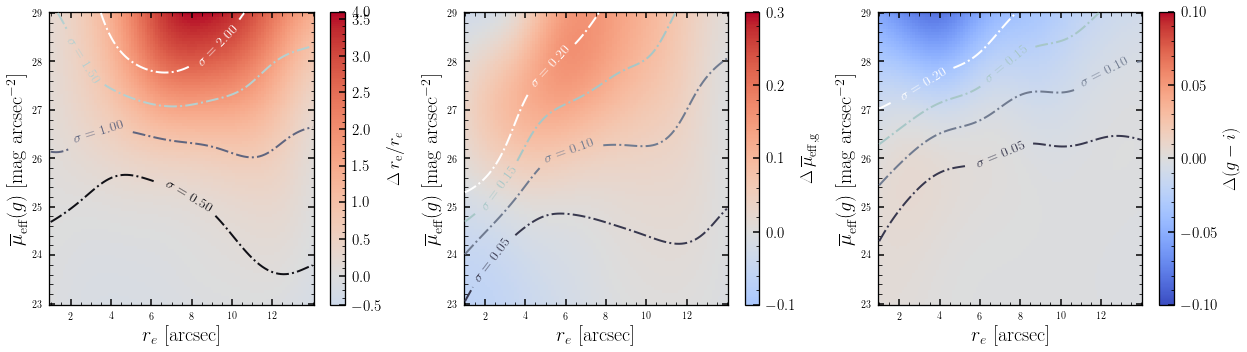

In [32]:
labelsize = 20
fig, axes = plt.subplots(1, 3, figsize=(17.5, 5), sharey=False, sharex=True)

x1_test, x2_test = np.meshgrid(np.linspace(1, 14, 100),
                               np.linspace(23, 29, 100))
###
plt.sca(axes[0])
ax = plt.gca()
filt = 'g'
re_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_bias_rbf.pkl')
re_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_std_rbf.pkl')

C_bias = (re_bias(np.vstack([x1_test.ravel(), x2_test.ravel()]).T))
re_meas_corr = x1_test.ravel() * (1 + C_bias)

C_bias *= x1_test.ravel()

C_std = re_std(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)# * re_meas_corr
C_std[C_std < 0.3] = 0.3
# C_std /= x1_test.ravel()

pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
#                     norm=MidpointNormalize(vmin=-0.4, vmax=0.6, midpoint=0),
                    norm=MidpointNormalize(vmin=-0.4, vmax=3.6, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'$\Delta\,r_{\rm e}/r_e$', size=18)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 levels=[0.5, 1.0, 1.5, 2.0], vmin=0.4, vmax=1.8, 
#                  levels=[0.05, 0.1, 0.15, 0.2], vmin=0.04, vmax=0.18, 
                 linewidths=2, linestyles='-.',
                 cmap='bone', 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt="$\sigma=%.2f$",
           inline=True, fontsize=14)
plt.xlabel(r'$r_{e}$ [arcsec]', fontsize=labelsize)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]', fontsize=labelsize)
plt.xticks(np.arange(2, 14, 2))

######
plt.sca(axes[1])
ax = plt.gca()
filt = 'g'
SB_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB/SB_eff_{filt}_bias_rbf.pkl')
SB_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB/SB_eff_{filt}_std_rbf.pkl')

C_bias = SB_bias(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_bias = x2_test.ravel() * (C_bias)
SB_meas_corr = x2_test.ravel() + C_bias
C_std = SB_std(np.vstack([x1_test.ravel(), x2_test.ravel()]).T) * SB_meas_corr
C_std[C_std < 0.04] = 0.04

pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.1, vmax=0.3, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, 
                    ticks=[-0.1, 0, 0.1, 0.2, 0.3])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'$\Delta\,\overline{\mu}_{\rm eff, g}$', size=18)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 levels=[0.05, 0.10, 0.15, 0.20],
                 cmap='bone', vmin=0., vmax=0.2, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=14)
plt.xlabel(r'$r_{e}$ [arcsec]', fontsize=labelsize)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]', fontsize=labelsize)

####### color ######
plt.sca(axes[2])
ax = plt.gca()

gi_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/color/gi_bias_rbf.pkl')
gi_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/color/gi_std_rbf.pkl')

C_bias = gi_bias(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = gi_std(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.02] = 0.02

pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.1, vmax=0.1, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, 
                    ticks=[-0.1, -0.05, 0, 0.05, 0.1])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label=r'$\Delta(g-i)$', size=18)

CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 levels=[0.05, 0.10, 0.15, 0.20],
                 cmap='bone', vmin=0., vmax=0.2, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=14)
plt.xlabel(r'$r_{e}$ [arcsec]', fontsize=labelsize)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]', fontsize=labelsize)

plt.tight_layout()
# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/meas_error_spergel.pdf', 
#             bbox_inches='tight')

# plt.subplots_adjust(wspace=0.3, hspace=0.06)

In [33]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

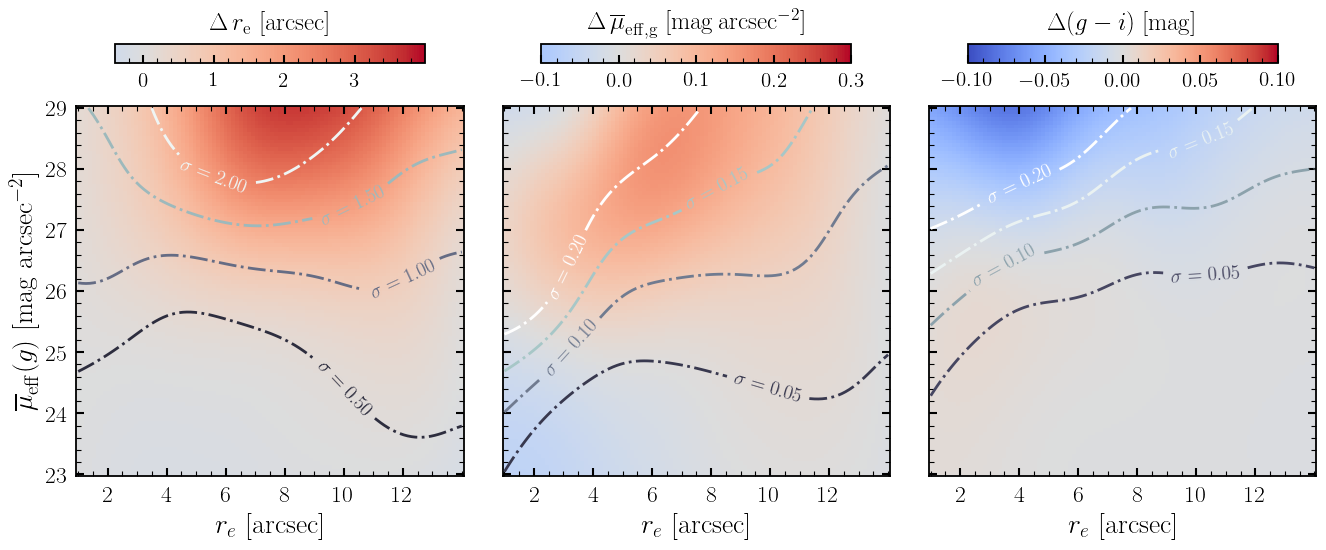

In [52]:
labelsize = 20
fig, axes = plt.subplots(1, 3, figsize=(16., 4.9), sharey=True, sharex=True)

x1_test, x2_test = np.meshgrid(np.linspace(1, 14, 100),
                               np.linspace(23, 29, 100))
###
plt.sca(axes[0])
ax = plt.gca()
filt = 'g'
re_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_bias_rbf.pkl')
re_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_std_rbf.pkl')

C_bias = (re_bias(np.vstack([x1_test.ravel(), x2_test.ravel()]).T))
re_meas_corr = x1_test.ravel() * (1 + C_bias)
C_std = re_std(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)# * re_meas_corr
C_std[C_std < 0.3] = 0.3
C_bias *= x1_test.ravel()

pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
#                     norm=MidpointNormalize(vmin=-0.4, vmax=0.6, midpoint=0),
                    norm=MidpointNormalize(vmin=-0.4, vmax=4., midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
#                  levels=[0.05, 0.1, 0.15, 0.2],
                 levels=[0.5, 1.0, 1.5, 2.0], vmin=0.1, vmax=2.1, 
                 linewidths=2, linestyles='-.',
                 cmap='bone',
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt="$\sigma=%.2f$",
           inline=True, fontsize=14)
plt.xlabel(r'$r_{e}$ [arcsec]', fontsize=labelsize)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]', fontsize=labelsize)
plt.xticks(np.arange(2, 14, 2))

ax_cbar = inset_axes(ax, width='80%', height='5%', loc='upper center',
                     bbox_to_anchor=(0, 0.2, 1, 1), 
                     bbox_transform=ax.transAxes)
cbar = plt.colorbar(pc, cax=ax_cbar, orientation='horizontal', 
#                     ticks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6]
                    ticks=[0, 1, 2, 3]
                   )
cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_title(r'$\Delta\,r_{\rm e}/r_e$', size=18)
cbar.ax.set_title(r'$\Delta\,r_{\rm e}$ [arcsec]', size=18)

######
plt.sca(axes[1])
ax = plt.gca()
filt = 'g'
SB_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB/SB_eff_{filt}_bias_rbf.pkl')
SB_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB/SB_eff_{filt}_std_rbf.pkl')

C_bias = SB_bias(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_bias = x2_test.ravel() * (C_bias)
SB_meas_corr = x2_test.ravel() + C_bias
C_std = SB_std(np.vstack([x1_test.ravel(), x2_test.ravel()]).T) * SB_meas_corr
C_std[C_std < 0.04] = 0.04

pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.1, vmax=0.3, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 levels=[0.05, 0.10, 0.15, 0.20],
                 cmap='bone', vmin=0., vmax=0.2, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=14)
plt.xlabel(r'$r_{e}$ [arcsec]', fontsize=labelsize)
# plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]', fontsize=labelsize)

ax_cbar = inset_axes(ax, width='80%', height='5%', loc='upper center',
                     bbox_to_anchor=(0, 0.2, 1, 1), 
                     bbox_transform=ax.transAxes)
cbar = plt.colorbar(pc, cax=ax_cbar, orientation='horizontal', 
                    ticks=[-0.1, 0, 0.1, 0.2, 0.3])
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'$\Delta\,\overline{\mu}_{\rm eff, g}$ [mag$\,$arcsec$^{-2}$]', size=18)

####### color ######
plt.sca(axes[2])
ax = plt.gca()

gi_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/color/gi_bias_rbf.pkl')
gi_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/color/gi_std_rbf.pkl')

C_bias = gi_bias(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = gi_std(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.02] = 0.02

pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.1, vmax=0.1, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 levels=[0.05, 0.10, 0.15, 0.20],
                 cmap='bone', vmin=0., vmax=0.16, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=14)
plt.xlabel(r'$r_{e}$ [arcsec]', fontsize=labelsize)
# plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]', fontsize=labelsize)

ax_cbar = inset_axes(ax, width='80%', height='5%', loc='upper center',
                     bbox_to_anchor=(0, 0.2, 1, 1), 
                     bbox_transform=ax.transAxes)
cbar = plt.colorbar(pc, cax=ax_cbar, orientation='horizontal', 
                    ticks=[-0.1, -0.05, 0, 0.05, 0.1])
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_title(r'$\Delta(g-i)$ [mag]', size=18)

# plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/meas_error_spergel.pdf', 
            bbox_inches='tight')

----

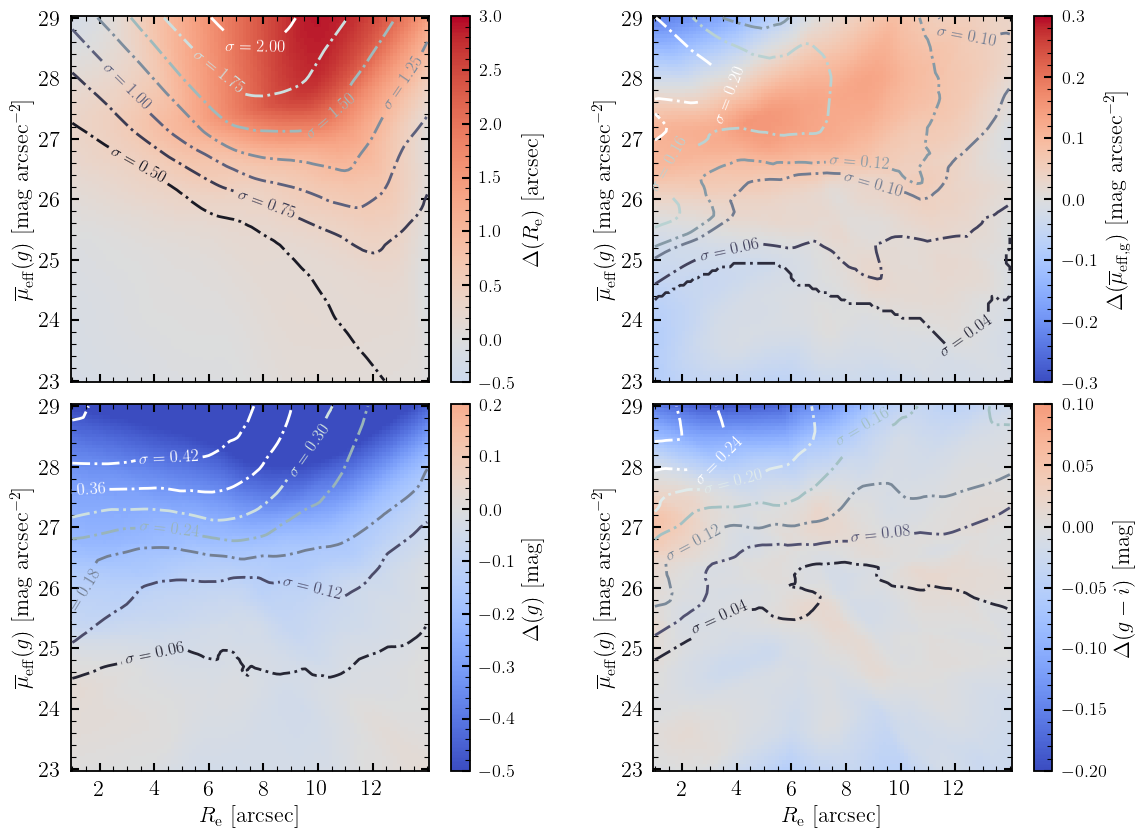

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(13.3, 10), sharey=False, sharex=True)

x1_test, x2_test = np.meshgrid(np.linspace(1, 14, 100),
                               np.linspace(23, 29, 100))
###
plt.sca(axes[0, 0])
ax = plt.gca()
filt = 'g'
re_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_bias.pkl')
re_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/re_std.pkl')

C_bias = re_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = re_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.3] = 0.3
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.4, vmax=3, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(R_{\rm e})$ [arcsec]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
            cmap='bone', vmin=0.3, vmax=2, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
plt.xticks(np.arange(2, 14, 2))

###
plt.sca(axes[0, 1])
ax = plt.gca()
filt = 'g'
SB_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB_eff_{filt}_bias.pkl')
SB_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/SB_eff_{filt}_std.pkl')

C_bias = SB_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = SB_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.04] = 0.04
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.3, vmax=0.3, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(\overline{\mu}_{\rm eff, g})$ [mag arcsec$^{-2}$]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 levels=[0.04, 0.06, 0.10, 0.12, 0.16, 0.20],
                 cmap='bone', vmin=0., vmax=0.2, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

###
plt.sca(axes[1, 0])
ax = plt.gca()
filt = 'g'
mag_bias = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/mag_{filt}_bias.pkl')
mag_std = joblib.load(f'./Catalog/mock_sample/spergel/bias_std/mag_{filt}_std.pkl')

C_bias = mag_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = mag_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.05] = 0.05
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.5, vmax=0.2, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(g)$ [mag]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 cmap='bone', vmin=0., vmax=0.35, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.xlabel(r'$R_{\rm e}$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

###
plt.sca(axes[1, 1])
ax = plt.gca()
C_bias = gi_bias.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std = gi_std.predict(np.vstack([x1_test.ravel(), x2_test.ravel()]).T)
C_std[C_std < 0.02] = 0.02
pc = plt.pcolormesh(x1_test, x2_test, C_bias.reshape(*x1_test.shape), 
                    norm=MidpointNormalize(vmin=-0.2, vmax=0.1, midpoint=0),
                    cmap='coolwarm',
                    alpha=1, rasterized=True)
cbar = plt.colorbar(pc, ax=ax, label=r'$\Delta(g-i)$ [mag]')
cbar.ax.tick_params(labelsize=13)
CS = plt.contour(x1_test, x2_test, C_std.reshape(*x1_test.shape), 
                 linewidths=2, linestyles='-.',
                 cmap='bone', vmin=0., vmax=0.22, 
                 alpha=1, zorder=10, rasterized=True)
plt.clabel(CS, CS.levels, fmt='$\sigma=%.2f$',
           inline=True, fontsize=12)
plt.xlabel(r'$R_{\rm e}$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

plt.subplots_adjust(wspace=0.3, hspace=0.06)

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/meas_error_spergel.pdf', 
#             dpi=30, bbox_inches='tight')